In [1]:
!pip install super-image -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.9/95.9 kB 5.3 MB/s eta 0:00:00


In [9]:
!unzip archive.zip




Archive:  archive.zip
  inflating: dataset/Raw Data/high_res/0.png  
  inflating: dataset/Raw Data/high_res/1.png  
  inflating: dataset/Raw Data/high_res/10.png  
  inflating: dataset/Raw Data/high_res/100.png  
  inflating: dataset/Raw Data/high_res/101.png  
  inflating: dataset/Raw Data/high_res/102.png  
  inflating: dataset/Raw Data/high_res/103.png  
  inflating: dataset/Raw Data/high_res/104.png  
  inflating: dataset/Raw Data/high_res/105.png  
  inflating: dataset/Raw Data/high_res/106.png  
  inflating: dataset/Raw Data/high_res/107.png  
  inflating: dataset/Raw Data/high_res/108.png  
  inflating: dataset/Raw Data/high_res/109.png  
  inflating: dataset/Raw Data/high_res/11.png  
  inflating: dataset/Raw Data/high_res/110.png  
  inflating: dataset/Raw Data/high_res/111.png  
  inflating: dataset/Raw Data/high_res/112.png  
  inflating: dataset/Raw Data/high_res/113.png  
  inflating: dataset/Raw Data/high_res/114.png  
  inflating: dataset/Raw Data/high_res/115.png  
  in

In [79]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from super_image import EdsrModel, ImageLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

In [80]:
lr_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

hr_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])


In [81]:
class SRDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, transform=None):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.lr_images = sorted(os.listdir(lr_dir))
        self.hr_images = sorted(os.listdir(hr_dir))
        self.lr_transform = lr_transform
        self.hr_transform = hr_transform
    def __len__(self):
        return len(self.lr_images)
    def __getitem__(self, idx):
        lr_path = os.path.join(self.lr_dir, self.lr_images[idx])
        hr_path = os.path.join(self.hr_dir, self.hr_images[idx])
        lr = Image.open(lr_path).convert("RGB")
        hr = Image.open(hr_path).convert("RGB")

        if self.lr_transform:
            lr = self.lr_transform(lr)
        if self.hr_transform:
            hr = self.hr_transform(hr)

        return lr, hr

In [82]:
base_path = "/content/dataset"
train_lr = os.path.join(base_path, "train/low_res")
train_hr = os.path.join(base_path, "train/high_res")
val_lr = os.path.join(base_path, "val/low_res")
val_hr = os.path.join(base_path, "val/high_res")

In [83]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [84]:
train_dataset = SRDataset(train_lr, train_hr, transform=transform)
val_dataset = SRDataset(val_lr, val_hr, transform=transform)

In [85]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [86]:
model = EdsrModel.from_pretrained('eugenesiow/edsr-base', scale=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

https://huggingface.co/eugenesiow/edsr-base/resolve/main/pytorch_model_2x.pt


In [87]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [88]:

num_epochs = 5
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for lr, hr in tqdm(train_loader):
        lr, hr = lr.to(device), hr.to(device)
        optimizer.zero_grad()
        outputs = model(lr).clamp(0, 1)
        loss = criterion(outputs, hr)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)


    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for lr, hr in val_loader:
            lr, hr = lr.to(device), hr.to(device)
            outputs = model(lr).clamp(0, 1)
            loss = criterion(outputs, hr)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

100%|██████████| 86/86 [00:10<00:00,  7.91it/s]


Epoch [1/5] - Train Loss: 0.0005, Val Loss: 0.0005


100%|██████████| 86/86 [00:11<00:00,  7.78it/s]


Epoch [2/5] - Train Loss: 0.0005, Val Loss: 0.0005


100%|██████████| 86/86 [00:10<00:00,  7.93it/s]


Epoch [3/5] - Train Loss: 0.0004, Val Loss: 0.0005


100%|██████████| 86/86 [00:10<00:00,  7.85it/s]


Epoch [4/5] - Train Loss: 0.0004, Val Loss: 0.0005


100%|██████████| 86/86 [00:10<00:00,  7.91it/s]


Epoch [5/5] - Train Loss: 0.0004, Val Loss: 0.0005


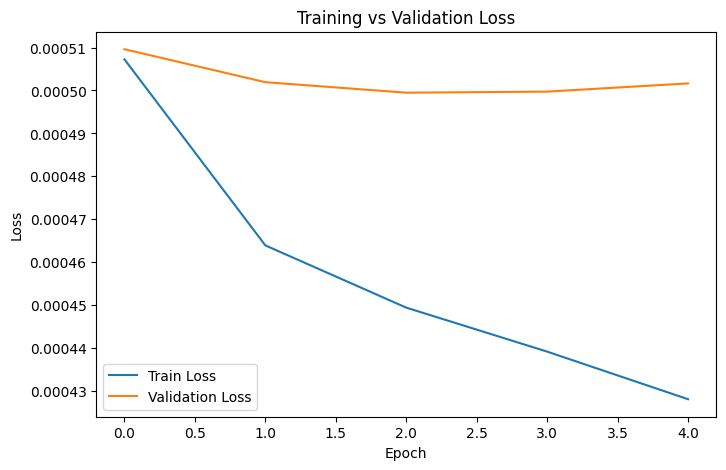

In [89]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()